In [ ]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-7opmg57_
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-7opmg57_
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit 94e20ea7e510ac4d665492b8bed8836a5143f16e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch  # PyTorch to convert values ino torch tensors.
from chronos import ChronosPipeline

In [ ]:
pipeline = ChronosPipeline.from_pretrained("amazon/chronos-t5-tiny",
                                            device_map = "auto",
                                            torch_dtype = torch.bfloat16)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [ ]:
series = pd.read_csv("/content/co-emissions-per-capita.csv") # import data
series.head()

,Entity,Code,Year,Annual CO₂ emissions (per capita)
0,Afghanistan,AFG,1949,0.001992
1,Afghanistan,AFG,1950,0.010837
2,Afghanistan,AFG,1951,0.011625
3,Afghanistan,AFG,1952,0.011468
4,Afghanistan,AFG,1953,0.013123


In [ ]:
series =  series[series['Entity'] == 'Sri Lanka']
series = series.drop(columns = ['Entity', 'Code'])
series = series.set_index('Year')
series.head()

,Annual CO₂ emissions (per capita)
Year,
1950,0.208271
1951,0.194303
1952,0.238921
1953,0.249691
1954,0.211231


<Axes: xlabel='Year'>

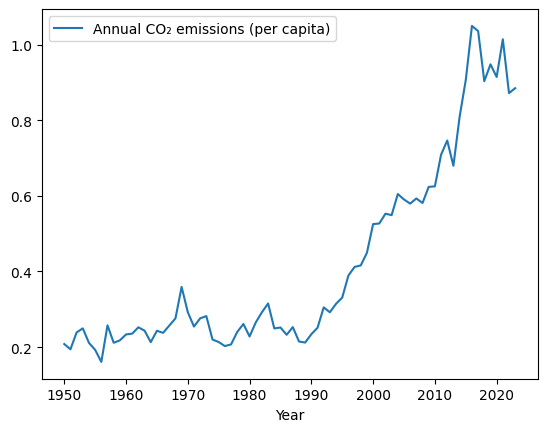

In [ ]:
series.plot()

In [ ]:
series.reset_index(inplace = True)

In [ ]:
series = series.rename(columns = {'Annual CO₂ emissions (per capita)' : 'Emissions'})
series.head()

,Year,Emissions
0,1950,0.208271
1,1951,0.194303
2,1952,0.238921
3,1953,0.249691
4,1954,0.211231


In [ ]:
len(series)

74

In [ ]:
forecast = pipeline.predict(
    context=torch.tensor(series["Emissions"]),
    prediction_length=10,
    num_samples=74,
)

NameError: name 'pipeline' is not defined

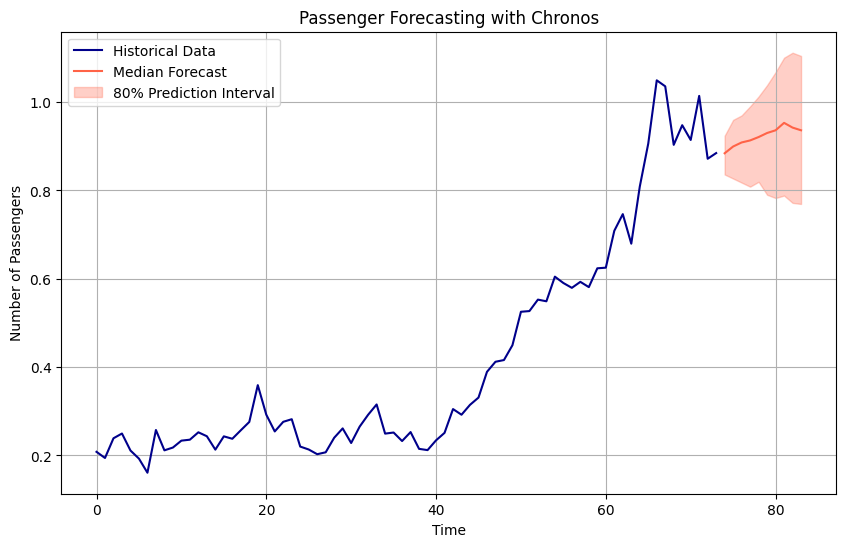

In [ ]:
forecast_index = range(len(series), len(series) + 10)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(series["Emissions"], color="darkblue", label="Historical Data")
plt.plot(forecast_index, median, color="tomato", label="Median Forecast")
plt.fill_between(forecast_index, low, high, color="tomato", alpha=0.3, label="80% Prediction Interval")
plt.legend()
plt.grid()
plt.xlabel("Time")
plt.ylabel("Number of Passengers")
plt.title("Passenger Forecasting with Chronos")
plt.show()

In [ ]:
df =  pd.read_csv("/content/data.csv")
df =  df.sort_index(ascending = False)
df = df.reset_index(drop = True)
df.head()

,Date,Exchange Rate
0,5/7/2010,136459.7395
1,5/11/2010,136684.5647
2,5/12/2010,139577.2499
3,5/13/2010,140790.1394
4,5/14/2010,140514.5200


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df['Exchange Rate']
# Now, you can format it as 'YYYY-MM-DD'
# df['Date'] = df['Date'].dt.strftime("%Y-%m-%d")
df.head()

,Date,Exchange Rate
0,2010-05-07,136459.7395
1,2010-05-11,136684.5647
2,2010-05-12,139577.2499
3,2010-05-13,140790.1394
4,2010-05-14,140514.5200


In [ ]:
def mean_scaling(x):
    mean = np.mean(np.abs(x))
    return x/mean

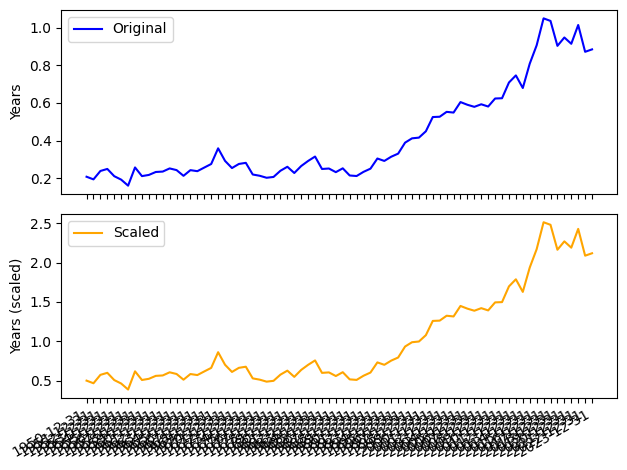

In [ ]:
y = df['Emissions'].values
y_scaled = mean_scaling(y)

fig, (ax1, ax2) = plt.subplots(ncols=1, nrows=2)

ax1.plot(series_up['Year'][:200], y[:200], color='blue', label='Original')
ax1.set_ylabel('Years')
ax1.legend()

ax2.plot(series_up['Year'][:200], y_scaled[:200], color='orange', label='Scaled')
ax2.set_ylabel('Years (scaled)')
ax2.legend()

fig.autofmt_xdate()
plt.tight_layout()


In [ ]:
import time
# from datasetsforecast.m3 import M3
# from utilsforecast.losses import *
# from utilsforecast.evaluation import evaluate
import torch
from tqdm.auto import tqdm

pipeline = ChronosPipeline.from_pretrained(
    "amazon/chronos-t5-large",
    device_map="auto",
    torch_dtype=torch.bfloat16,
)

horizon = 5
batch_size = 10


actual = []
chronos_large_preds = []

all_timeseries = [
    torch.tensor(series["Emissions"].values[:-horizon])
]
for i in tqdm(range(0, len(all_timeseries), batch_size)):
    batch_context = all_timeseries[i : i + batch_size]
    forecast = pipeline.predict(batch_context, horizon)
    predictions = np.quantile(forecast.numpy(), 0.5, axis=1)

    chronos_large_preds.append(predictions)

chronos_large_preds = np.concatenate(chronos_large_preds)
print(chronos_large_preds)

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[[0.85605311 0.83653399 0.8672069  0.84489936 0.86162999]]


range(74, 79)


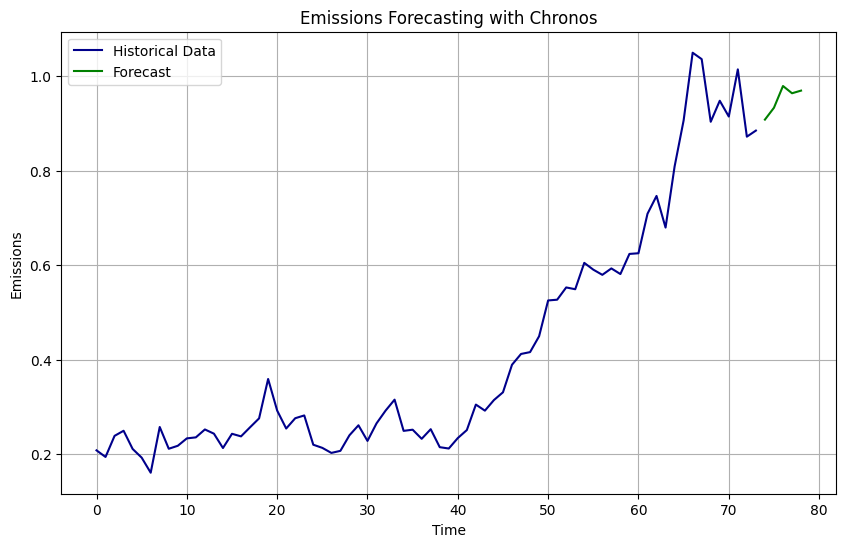

In [ ]:
import matplotlib.pyplot as plt

# Assuming the actual data and forecasted data are available
# Example of appending predictions to the original time series:
forecast_index = range(len(series), len(series) + horizon)  # Adjust for the forecast horizon
print(forecast_index)
# Plot the historical emissions data
plt.figure(figsize=(10, 6))
plt.plot(series["Emissions"], color="darkblue", label="Historical Data")

# Plot the forecasted emissions
plt.plot(forecast_index, chronos_large_preds.flatten(), color="green", label="Forecast")

# Optionally, plot an interval (e.g., 80% prediction interval)
# This can be done if you save quantiles for high and low prediction intervals as well.

plt.legend()
plt.xlabel("Time")
plt.ylabel("Emissions")
plt.title("Emissions Forecasting with Chronos")
plt.grid()
plt.show()


In [ ]:
rows = { "chronos_large_pred": []}
for large_pred in chronos_large_preds:
    rows["chronos_large_pred"].extend(large_pred)

chronos_pred_df = pd.DataFrame(rows)
chronos_pred_df

,chronos_large_pred
0,"[0.7528470158576965, 0.7623617053031921, 0.779..."


In [ ]:
chronos_pred_df.plot()

TypeError: no numeric data to plot